# Set up

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-03-16 11:05:07.707238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Convolutional Layers

## Implementing Convolutional Layers with Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70x120 images.

In [2]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

2024-03-16 11:05:10.335304: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


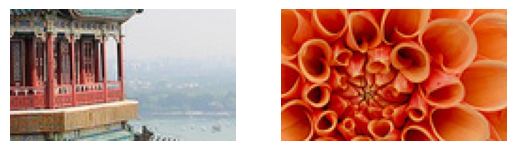

In [3]:
for img_idx in [0, 1]:
    plt.subplot(1, 2, img_idx + 1)
    plt.imshow(images[img_idx])
    plt.axis("off")
plt.show()

In [4]:
images.shape

TensorShape([2, 70, 120, 3])

In [5]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
filter_maps = conv_layer(images)

In [6]:
filter_maps.shape

TensorShape([2, 64, 114, 32])

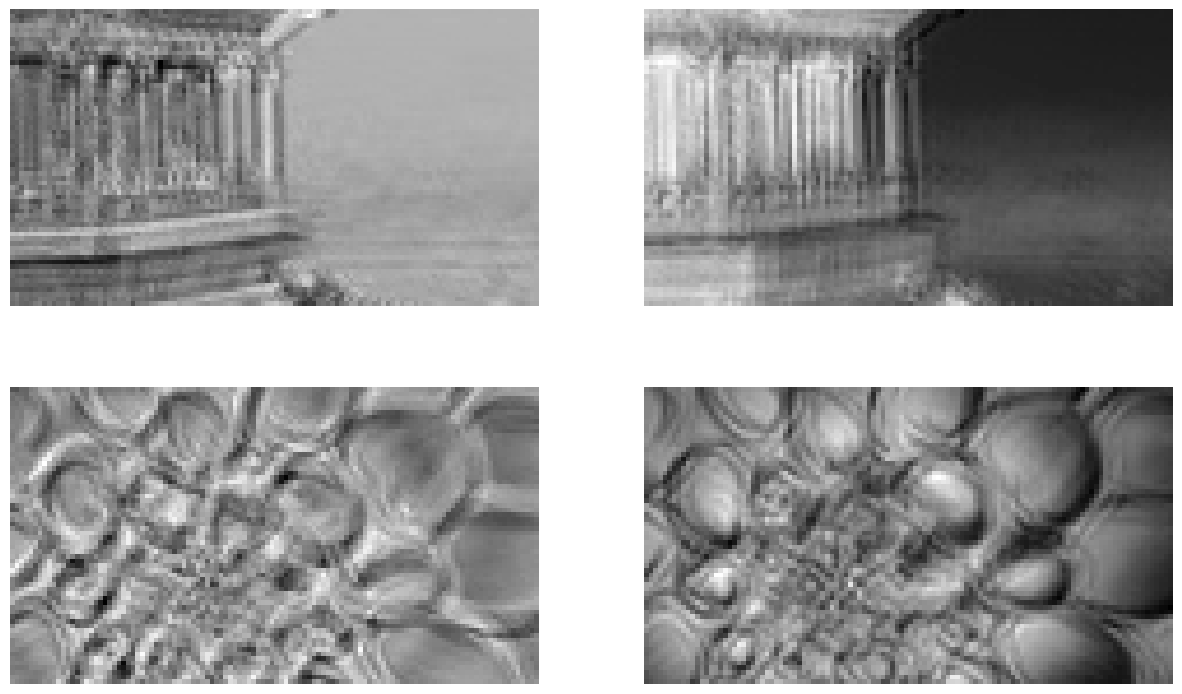

In [7]:
# Extra code displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for filter_map_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + filter_map_idx + 1)
        plt.imshow(filter_maps[image_idx, :, :, filter_map_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
filter_maps = conv_layer(images)
filter_maps.shape

TensorShape([2, 70, 120, 32])

In [9]:
# extra code - shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(
    filters=32, kernel_size=7, padding="same", strides=2
)
filter_maps = conv_layer(images)
filter_maps.shape

TensorShape([2, 35, 60, 32])

In [10]:
# extra code - this utility function can be useful to compute the size of the feature maps output by a convolutional layer. It also returns the number of ignored rows or columns if padding="valid", or the number of zero-padded rows or columns if padding="same".
def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding == "valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

Now let's look at the weights.

In [13]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [14]:
biases.shape

(32,)

In [15]:
# Extra code shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
filter_maps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Now we manually create two filters full of zeros, expect for a vertical line of 1s in the first filter, and a horizontal one in the second filter. The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice, you will never need to create filters manually, since the convolutional layers will learn them automatically.

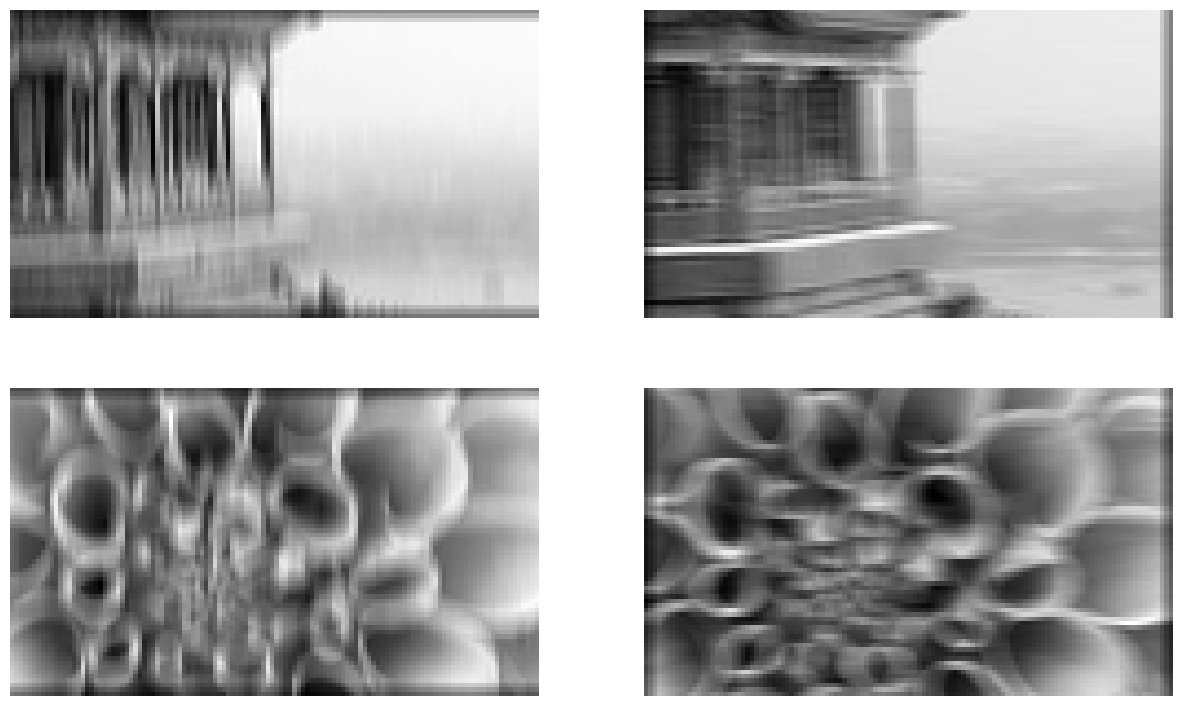

In [20]:
# Extra code shows how to manually create two filters to get images similar to those in note.md.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
filter_maps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for filter_map_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + filter_map_idx + 1)
        plt.imshow(filter_maps[image_idx, :, :, filter_map_idx], cmap="gray")
        plt.axis("off")
plt.show()

- Notice that dark lines at the bottom and top of the left images, and at the left and right of the right images. Recall that they didn't appear in the previous figure, then why they appear in this case?
- These are artifacts due to the fact that we use zero padding in this case.
- Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and the bottom of images.
- Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and the right of images.